In [1]:
from os import listdir

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
from nltk.metrics.distance import edit_distance

In [2]:
MISSING = " "

# Load Data

## Charts

In [3]:
files = listdir("../chart")

dfs_chart = {}
for f in files:
    year = f.split("_")[0]
    month = f.split("_")[1].split(".")[0]

    if dfs_chart.get(year) is None:
        dfs_chart[year] = {}
        
    dfs_chart[year][month] = pd.read_csv("../chart/" + f)

In [4]:
dfs_chart["2006"]["Janvier"].head(3)

,Rank,Artist,Music
0,1,juanes,la camisa negra
1,2,madonna,hung up
2,3,johnny hallyday,mon plus beau noël


In [5]:
chart = []
for k1 in dfs_chart.keys():
    for k2 in dfs_chart[k1].keys():
        chart.append(dfs_chart[k1][k2])
chart = pd.concat(chart)
chart.drop(columns=["Rank"], inplace=True)
chart.drop_duplicates(inplace=True)

## Artists

In [6]:
artist = pd.read_csv("../artist.csv", index_col=0)
artist.fillna(MISSING, inplace=True)

In [7]:
artist.head(3)

,Artist_wiki,Naissance,Pays d'origine,Origine,Nationalité,Pays,Summary
Artist,,,,,,,
jonas brothers,Jonas Brothers,,états-unis,,,états-unis,les jonas brothers est un groupe américain de ...
bob taylor,Bob Taylor,1955,,,américaine,,bob taylor est un luthier américain.
yvonne s. moriarty,,,,,,,


# Analysis

## Analyse des pages wikipédia

In [8]:
artist.value_counts("Artist_wiki").sort_values() #Aucune page en wiki en double, ce qui est un bon signe !

Artist_wiki
LCD Soundsystem      1
1995 (groupe)        1
2 Chainz             1
24kGoldn             1
2NE1                 1
                  ... 
Zkr                  1
Yuksek               1
Zoe Wees             1
MANUEL              17
                   528
Length: 1701, dtype: int64

In [9]:
np.round(artist[artist["Artist_wiki"] == MISSING].shape[0] / artist.shape[0], 2) # 24% des artistes n'ont pas de page en wiki

0.24

In [10]:
chart_c = chart.copy().merge(artist, left_on="Artist", right_on="Artist", how="left")

In [11]:
#Affiche le nb de fois qu'un artiste, sur qui nous n'avons pas donnée, est dans le top 50
chart_c[chart_c["Artist_wiki"] == MISSING].groupby("Artist")["Music"].count().sort_values(ascending=False)

Artist
astrofonik            6
frédérique zoltane    5
narkotek              4
lylloo                3
string color          3
                     ..
gums                  1
guirri mafia          1
groove cats           1
graya                 1
öwnboss               1
Name: Music, Length: 528, dtype: int64

In [12]:
#On recalcul les distances entre les noms d'artistes et les pages wikipédia pour vérifier
def calc_dist(artist, wiki):
    words = ["(chanteur)", "(chanteuse)", "(groupe)", "(rappeur)", "(rappeuse)", "(musicien)", "(chanteur français)", "(france)", "(producteur)", "(artiste)", "(groupe de musique)"]

    if any(w in wiki.lower() for w in words):
        dist = edit_distance(artist.lower().strip(), wiki.lower().split(" (")[0].strip())
        if dist/len(artist) < 0.4:
            return dist
    
    return edit_distance(artist.lower().strip(), wiki.lower().strip())

artist["distance"] = artist.apply(lambda x: calc_dist(x.name, x["Artist_wiki"]), axis=1)
artist["distance_norm"] = artist.apply(lambda x : x["distance"]/len(x.name), axis=1)

In [13]:
artist[artist["Artist_wiki"] != MISSING].sort_values("distance_norm", ascending=False).head() #Nos distances sont bonnes

,Artist_wiki,Naissance,Pays d'origine,Origine,Nationalité,Pays,Summary,distance,distance_norm
Artist,,,,,,,,,
isk,MANUEL,20 mars 2003,,,française,,"ISK, de son vrain nom Kais Ben Baccar, est un ...",6,2.00
glk,MANUEL,,,,française,,"Originaire de Bobigny, en Seine-Saint-Denis",6,2.00
dry,MANUEL,19 novembre 1977,,,française,,Landry Delica a grandi à Sevran en Seine-Saint...,6,2.00
yaro,MANUEL,1996,,,française,,"Yaro, anciennement Sirsy, est un rappeur franç...",5,1.25
1pliké140,MANUEL,1963,,,française,,1PLIKÉ140 est un jeune rappeur français origin...,9,1.00


## Analyse des données sur wikipédia

In [14]:
artist = artist[artist["Artist_wiki"] != MISSING] #On ne garde que les artistes qui ont une page en wiki

In [15]:
#Ajout de la colonne "Missing" pour voir ceux sur qui on n'a pas de données
artist["No data"] = (
    (artist["Naissance"] == MISSING) &
    (artist["Pays d'origine"] == MISSING) &
    (artist["Origine"] == MISSING) &
    (artist["Nationalité"] == MISSING) &
    (artist["Pays"] == MISSING) &
    (artist["Summary"] == MISSING)
)

In [16]:
chart_c = chart.copy().merge(artist, left_on="Artist", right_on="Artist", how="right")

In [17]:
chart_c[chart_c["No data"]].groupby("Artist")["Music"].count().sort_values(ascending=False)[:20]

Artist
rio             3
train           2
jumpy           2
digital         2
infernal        2
africanism      1
mig             1
pearl           1
pat             1
nour            1
noa             1
moonlight       1
michael gray    1
martial         1
marnik          1
mario           1
majestic        1
mag             1
lumberjack      1
petey           1
Name: Music, dtype: int64

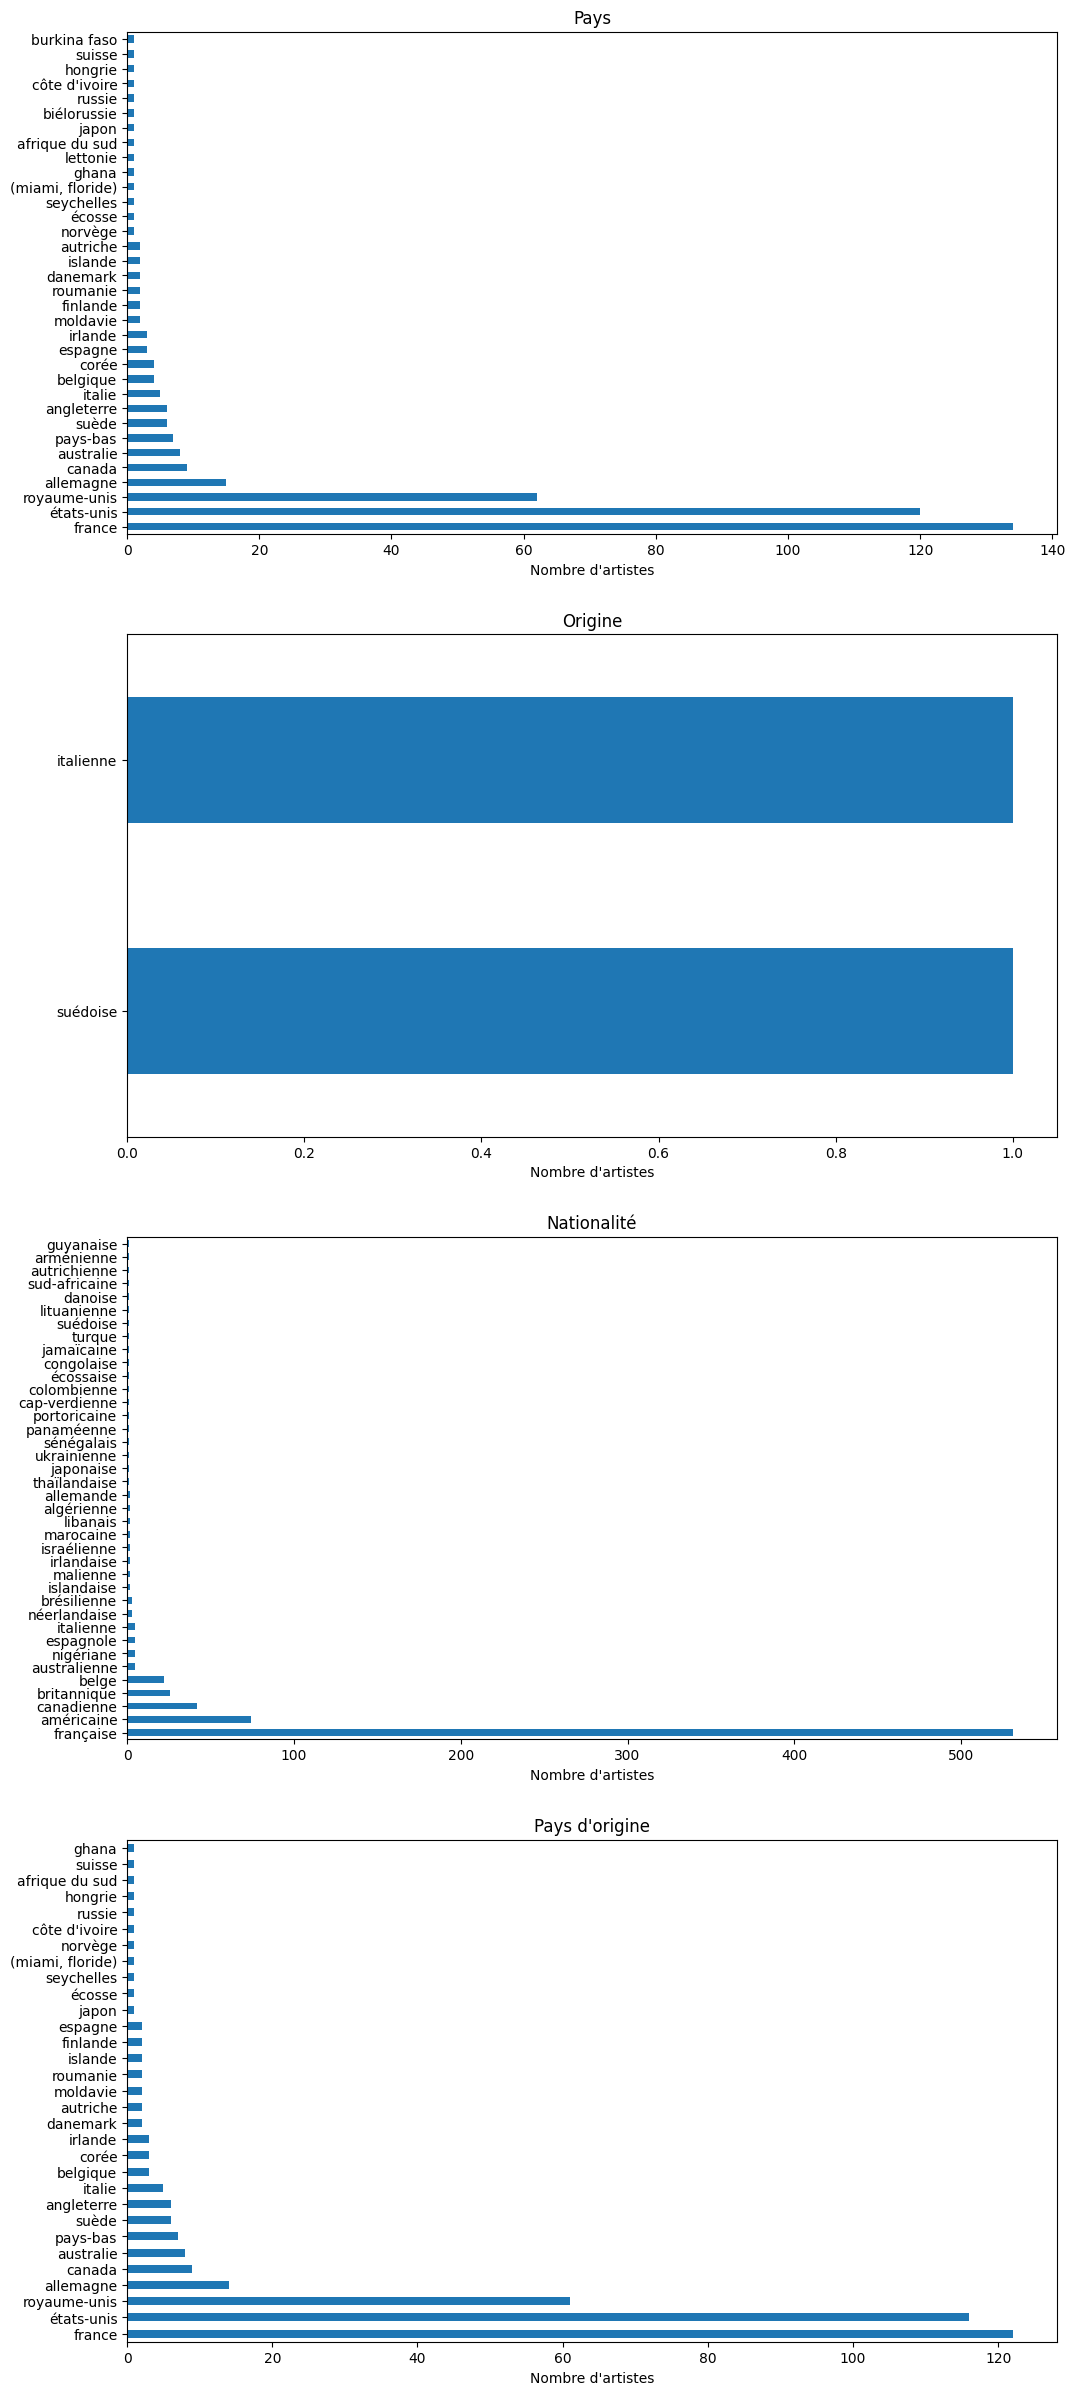

In [18]:
fig, ax = plt.subplots(4, 1, figsize=(12, 30))
for axi, col in zip(ax.flatten(), ["Pays", "Origine", "Nationalité", "Pays d'origine"]):
    artist[col].value_counts()[1:].plot.barh(ax=axi, title=col)
    axi.set(xlabel="Nombre d'artistes")

In [19]:
artist = artist[~artist["No data"]] #On ne garde que les artistes pour lesquels on a des données

In [20]:
def get_nationality(row, words):
    for r in words:
        regex = r"([\d)()\] ]|^)"+ r.lower() + r"([.,\[) ]|$)"

        if not re.search(regex, row["Summary"].lower()) is None:
            return r.lower()
    return MISSING

In [21]:
#On utilise le summary pour récupérer la nationalité
avant = artist[artist["Nationalité"] == MISSING].shape[0]

artist.loc[artist["Nationalité"] == MISSING, "Nationalité"] = artist[artist["Nationalité"] == MISSING].apply(lambda x: get_nationality(x, artist["Nationalité"].unique()), axis=1)

apres = artist[artist["Nationalité"] == MISSING].shape[0]

print(avant - apres) #On a récupéré 196 nationalités

196


In [22]:
def get_pays(row, words):
    for r in words:
        regex = r"([\d)()\] ]|^)"+ r.lower() + r"([.,\[) ]|$)"

        if not re.search(regex, row["Naissance"].lower()) is None:
            return r.lower()
    return MISSING

In [23]:
#On utilise le summary pour récupérer la Pays
avant = artist[artist["Pays"] == MISSING].shape[0]

artist.loc[artist["Pays"] == MISSING, "Pays"] = artist[artist["Pays"] == MISSING].apply(lambda x: get_nationality(x, artist["Pays"].unique()), axis=1)

apres = artist[artist["Pays"] == MISSING].shape[0]

print(avant - apres) #On a récupéré 130 Pays

130


In [24]:
avant = artist[artist["Nationalité"] == MISSING].shape[0]

In [25]:
#On récupère la nationalité à partir du pays
pays_replace = [
    ("française", "france"),
    ("américaine", "états-unis"),
    ("britannique", "royaume-unis"),
    ("britannique", "angleterre"),
    ("canadienne", "canada"),
    ("belge", "belgique"),
    ("allemande", "allemagne"),
    ("néerlandaise", "pays-bas"),
    ("australienne", "australie"),
    ("suédoise", "suède"),
    ("italienne", "italie"),
    ("espagnole", "espagne"),
    ("suisse", "suisse"),
    ("irlanndaise", "irlande"),
    ("écossaise", "écosse"),
    ("coréenne", "corée"),
    ("norvégienne", "norvège"),
    ("roumaine", "roumanie"),
    ("autrichienne", "autriche"),
    ("africaine", "afrique"),
    ("islandaise", "islande"),
    ("moldave", "moldavie"),
    ("danoise", "danemark"),
    ("japonaise", "japon"),
    ("russe", "russie"),
    ("finlandaise", "finlande"),
    ("ivoirienne", "côte d'ivoire"),
    ("seychelloise", "seychelles"),
    ("lettonne", "lettonie"),
    ("burkinabé", "burkina faso"),
    ("biélorusse", "biélorussie"),
    ("ghanaise", "ghana"),
    ("hongroise", "hongrie"),
]

for n1, n2 in pays_replace:
    artist.loc[(artist["Nationalité"] == MISSING) & (artist["Pays"] == n2), "Nationalité"] = n1
    artist.loc[(artist["Nationalité"] == MISSING) & (artist["Pays d'origine"] == n2), "Nationalité"] = n1

In [26]:
# Les origines sont transposées avec sur la nationalité
artist.loc[(artist["Nationalité"] == MISSING) & (artist["Origine"] != MISSING), "Nationalité"] = artist.loc[(artist["Nationalité"] == MISSING) & (artist["Origine"] != MISSING), "Origine"]

In [27]:
apres = artist[artist["Nationalité"] == MISSING].shape[0]
print(avant - apres) #On a récupéré 284 nationalités

284


In [28]:
artist["Nationalité"].value_counts()

française        555
                 405
américaine       257
britannique      150
canadienne        47
belge             24
allemande         20
suédoise          20
australienne      18
espagnole         16
italienne         15
néerlandaise      14
suisse            10
nigériane          5
écossaise          5
coréenne           5
islandaise         4
danoise            4
brésilienne        4
japonaise          4
marocaine          4
roumaine           3
irlandaise         3
colombienne        3
irlanndaise        3
autrichienne       3
moldave            3
jamaïcaine         3
libanais           2
algérienne         2
malienne           2
israélienne        2
norvégienne        2
ivoirienne         2
finlandaise        2
russe              2
sénégalais         1
cap-verdienne      1
ghanaise           1
panaméenne         1
ukrainienne        1
burkinabé          1
seychelloise       1
portoricaine       1
lituanienne        1
lettonne           1
congolaise         1
turque       

# Francophone

# Commune france

In [125]:
region = pd.read_csv("../france/departements-france.csv")
departement = pd.read_csv("../france/departements-france.csv")
commune = pd.read_csv("../france/nb_habitant.csv")

In [126]:
commune["nb_habitant"] = commune["nb_habitant"].str.replace(" ", "")
commune["nb_habitant"] = commune["nb_habitant"].astype("int")

In [127]:
def get_localisation(row, localisation):
    for r in localisation:
        regex = r"([\d)()\] ]|^)"+ r.lower() + r"([.,\[) ]|$)"

        if (not re.search(regex, row["Summary"].lower()) is None) or (not re.search(regex, row["Naissance"].lower()) is None):
            return r.lower()
    return MISSING

In [128]:
artist["Region"] = artist.apply(lambda x: get_localisation(x, region["nom_region"]), axis=1)

In [129]:
artist["Commune"] = artist.apply(lambda x: get_localisation(x, commune[commune["nb_habitant"] > 2000]["Ville"]), axis=1)

In [130]:
artist["Departement"] = artist.apply(lambda x: get_localisation(x, departement["nom_departement"]), axis=1)

In [139]:
for col in ["Region", "Commune", "Departement"]:
    print("-"*50)
    print(col)
    print("-"*50)
    print(artist[col].value_counts()[1:])
    print("Total : ", artist[col].value_counts()[1:].sum())

--------------------------------------------------
Region
--------------------------------------------------
guadeloupe                    7
guyane                        5
bretagne                      3
martinique                    3
provence-alpes-côte d'azur    3
normandie                     2
hauts-de-france               2
la réunion                    1
corse                         1
pays de la loire              1
île-de-france                 1
Name: Region, dtype: int64
Total :  29
--------------------------------------------------
Commune
--------------------------------------------------
paris                  86
marseille              21
nice                   11
lyon                    9
toulouse                7
                       ..
pontoise                1
chambray-lès-tours      1
saint-cyr-l'école       1
tassin-la-demi-lune     1
yerres                  1
Name: Commune, Length: 198, dtype: int64
Total :  439
--------------------------------------------------

In [132]:
artist["No localisation"] = (
    (artist["Region"] == MISSING) &
    (artist["Commune"] == MISSING) &
    (artist["Departement"] == MISSING)
)

In [133]:
artist.to_csv("../test_localisation.csv", encoding="utf-8-sig")